In [13]:
import requests
import empiricaldist
import janitor
import matplotlib.pyplot as plt
import numpy as np
import palmerpenguins
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as ss
import session_info

# Preparacion de los datos

Descarga del archivo

In [14]:
DataFrame_Pinguinos=pd.read_csv('https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv',
              names=['Especies','Isla','Longitud_Pico_mm','Profundidad_Pico_mm',
                    'Longitud_Aleta_mm','Masa_gr','Sexo','Anio'],header=0)

In [15]:
%matplotlib inline
sns.set_style('whitegrid')#Cambia la forma del cuadro
sns.set_context('notebook')#paper, notebook, talk, poster
plt.rcParams['figure.figsize'] = (11, 9.4)
Color_Pinguino = {
    'Adelie': '#ff6602ff',
    'Gentoo': '#0f7175ff',
    'Chinstrap': '#c65dc9ff'
}

# Manejo de valores nulos en los datos

Grafica de alfombra de los valores nulos

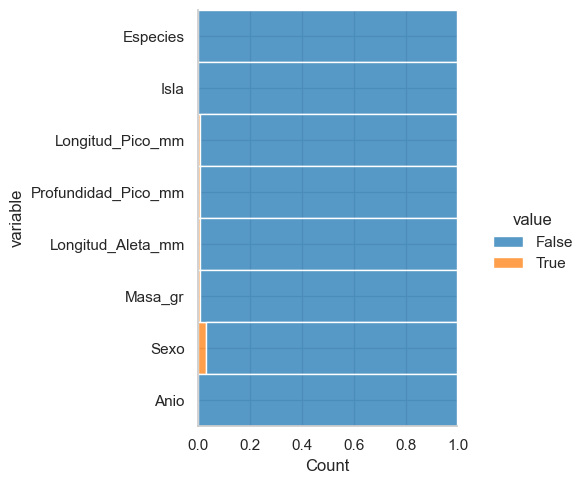

In [16]:
(
    DataFrame_Pinguinos
    .isnull()#Arroja los valores nulos
    .melt()#Pone variables y valores alineadas en tabla en forma variable-value
    .pipe(#Nos permite hacer funciones en dataframe
        lambda Data_Frame:(
            sns.displot(#Nos permite generar un histograma
                data=Data_Frame,
                y='variable',#eje y estaran los valores de la linea variables
                hue='value',#hue variable que se asigna pra determinar el color de los elementos en la trama
                multiple='fill'#La forma de la grafica
            )
        )
    )
)

heatmap de los valores nulos

<AxesSubplot: >

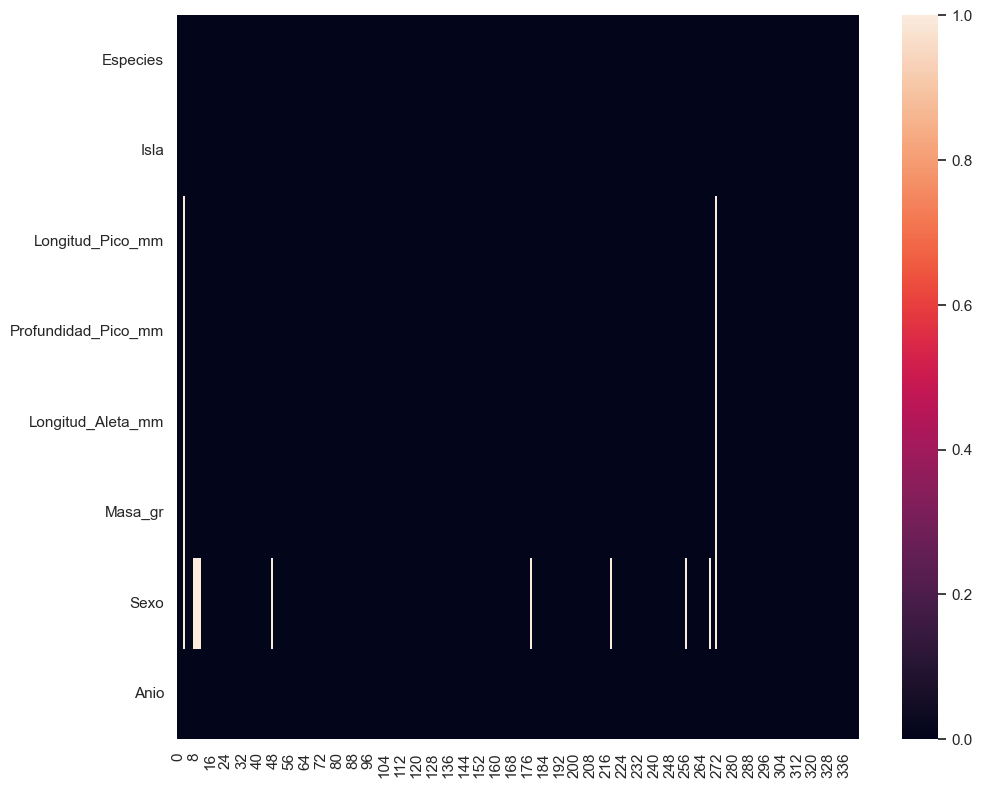

In [17]:
(
    DataFrame_Pinguinos
    .isnull().T
    .pipe(
        lambda Data_Frame:(sns.heatmap(data=Data_Frame))
    )
)

# Conociendo nuestros datos 

Observando y separando nuestros datos

In [18]:
Datos_Estadisticos_General=DataFrame_Pinguinos.describe(include='all')#Conociendo los valores estadisticos
Datos_Estadisticos_Numericos=DataFrame_Pinguinos.describe(include=[np.number])
Datos_Estadisticos_Categoricos=DataFrame_Pinguinos.describe(include=object)

# Graficando nuestros datos

Grafica de barra de aparicion de nuestros pinguinos

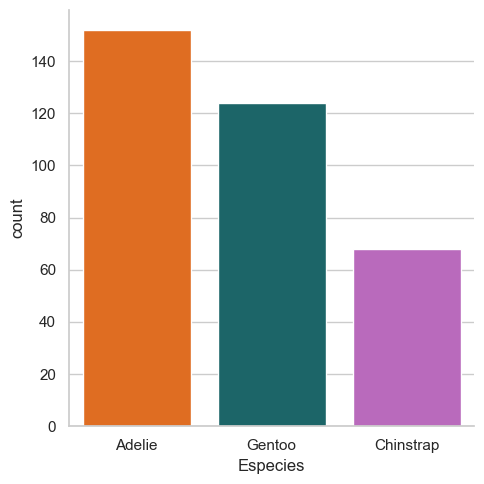

In [19]:
sns.catplot(
    data=DataFrame_Pinguinos,
    x='Especies',
    kind='count',#“strip”, “swarm”, “box”, “violin”, “boxen”, “point”, “bar”, or “count”.(count en este caso)
    palette=Color_Pinguino
)

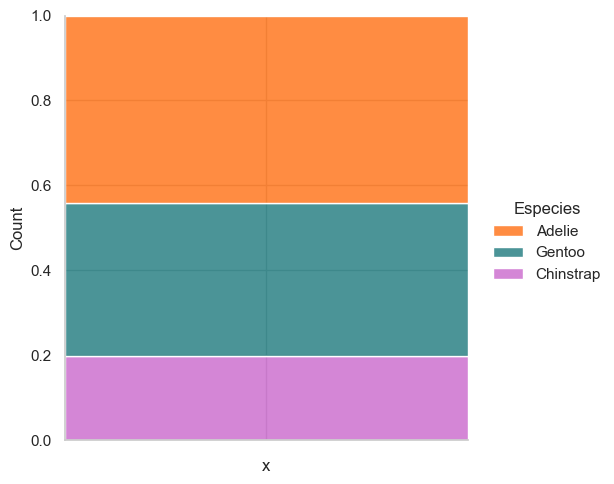

In [20]:
DataFrame_Pinguinos.add_column('x','').pipe(lambda Data_Frame:(sns.displot(
                                                                data=Data_Frame,
                                                                x='x',
                                                                hue='Especies',
                                                                multiple='fill',
                                                                palette=Color_Pinguino)))


# Histograma

El histograma merece un capitulo individual, pues es una herramienta facil de usar pero contiene bastantes parametros si es que queremos hacer un buen histograma

Hay una funcion escencial que debemos tener en cuenta siempre que grafiquemos alun histograma, y es freedman_diaconis_binwidth ¿Que es lo que hace? pues bien, hay un valor en seaborns.histplot, y es binwidth, que es masomenos que tan delgadas o anchas son las graficas, un binwidth mal ajustado puede significar un histograma mal hecho, por eso mismo, esta funcion se encarga de ajustar el binwidth por medio de los cuartiles, solo debemos pasarle el dato que queremos graficar, y nos retornara un valor que posteriormente deberemos poner como binwidth

In [21]:
def freedman_diaconis_binwidth(x:pd.Series)->float:
    IQR=x.quantile(0.75)-x.quantile(.25)
    N=x.size
    return 2*IQR/N**(1/3)

Graficando Histograma de longitud de la aleta de la especie Adelie

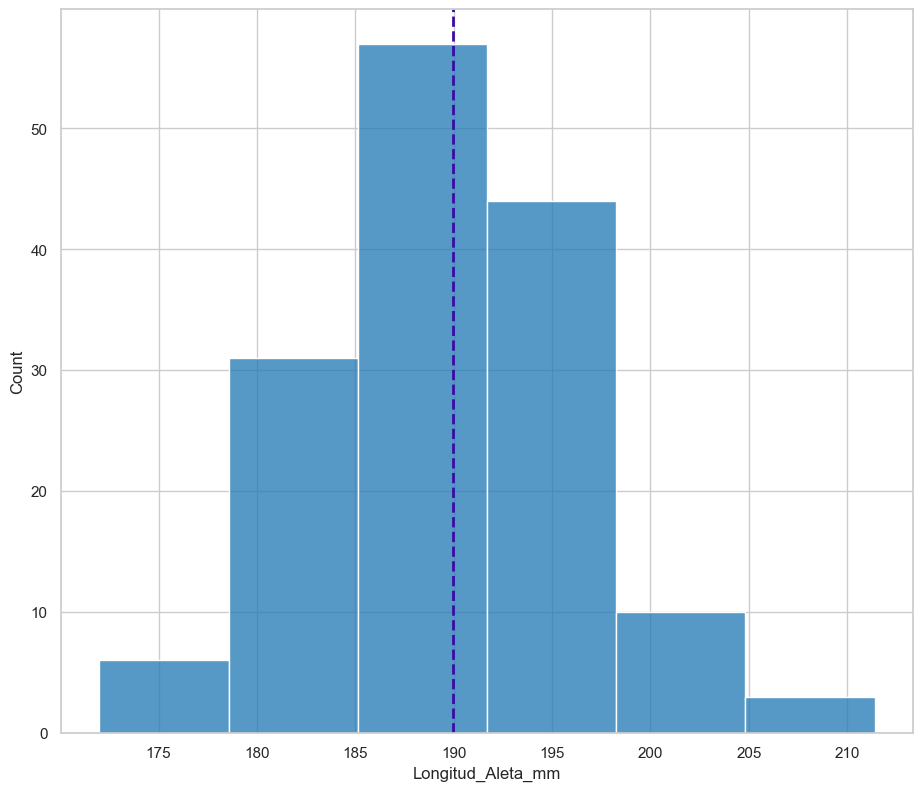

In [23]:
binwidth_ajustado=freedman_diaconis_binwidth(DataFrame_Pinguinos.Longitud_Aleta_mm)

Pinguinos_Adelie=DataFrame_Pinguinos[DataFrame_Pinguinos['Especies']=='Adelie']

sns.histplot(data=Pinguinos_Adelie,x='Longitud_Aleta_mm',binwidth=binwidth_ajustado)

plt.axvline(#Media
    x=Pinguinos_Adelie.Longitud_Aleta_mm.mean(),
    color="#3a0ca3",
    linestyle='--', #: = dotted
    linewidth=2
)

# Funciones de probabiliad

PMFs

In [ ]:
Probabiliad_Adelie_Ala=empiricaldist.Pmf.from_seq(Pinguinos_Adelie.Longitud_Aleta_mm)
Probabiliad_Adelie_Ala(190)

In [ ]:
Probabiliad_Adelie_Ala=empiricaldist.Cdf.from_seq(Pinguinos_Adelie.Longitud_Aleta_mm,normalize=True)
Probabiliad_Adelie_Ala(205)

# Relacion entre variables

Muchas veces para llevar a cabo ciertas investigaciones estadisticas, es necesario saber si ciertas variables estan relacionadas entre si, a continuacion veremos diversas graficas, metodos, y funciones que nos ayudaran a ver si ciertas variables estan relacionadas, OJO el hecho de que haya una correlacion fuerte no significa que una cause a la otra,  esto puede caer en la paradoja de Simpson

Ajustando los datos

In [ ]:
DataFrame_Pinguinos=DataFrame_Pinguinos.assign(sexo_num=lambda df:df.Sexo.replace(['female','male'],[0,1]))
                                                                    
Correlacion_Variables=DataFrame_Pinguinos.corr()

Matriz de correlacion

In [ ]:
sns.heatmap(data=Correlacion_Variables,annot=True,center=0,vmax=1,vmin=-1)

# Validando una relacion entre las variables

Okei, ahora queremos ver si la especie, isla y masa determina de cierta manera el tamaño de las aletas

In [ ]:
DataFrame_Pinguinos.dropna(inplace=True)#Muy importante, antes de todo,  eliminar los valores
Modelo=smf.ols(formula='Longitud_Aleta_mm ~ C(Especies)+C(Isla)+Masa_gr',data=DataFrame_Pinguinos).fit()
Modelo.summary()

Veremos diversas cosas importantes, entre ellas, la que mas destaca, es R-squared, que es el nivel de confianza o nivel de "union" por decirlo de cierta manera que tienen estas variables. Ahora, veamos como se comportan en el grafico

# Predicciones 

Muy bien, acabamos de ver que si, si tienen relacion,  pero es suficiente la relacion como para poder predecir valores? es decir, que con saber, el peso,  la isla y la especie es suficiente para saber cuanto exactamente medira su aleta? Bien, quiza no exactamente pero quiza nos acerquemos, veamos

In [ ]:
Modelo_Prediccion=pd.DataFrame(dict(Valor_Real=Sinvalores.Longitud_Aleta_mm,Prediccion=Modelo.predict()))
Modelo_Prediccion.describe()

Grafiquemos

In [ ]:
sns.ecdfplot(data=Comparacion_Modelo)